# Product Clustering

**Goal**: Starting from a collection of markets along with their *product instances* (that's how we'll call products as they appear in a market, e.g. "Azeite Andorinha 500ml" or "Azeite de Oliva Andorinha 0,5L"), we want to combine equivalent products instances into a *product type*. **We may assume the product instances were already tagged by our NER model**

**Choosing a clustering algorithm:** \
We want to:
- avoid algorithms with prefixed numbers of clusters (since it is variable)
- avoid algorithms that take toooo long
- use algorithms that accept a graph or a custom metric as input (since we are dealing with strings, not with N-dimensional points in euclidian space)

**Some interesting candidates:**
- [~~Agglomerative Clustering with single-linkage~~](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) --> too much memory
    - use the `connectivity` argument in sklearn implamentation to avoid clusters withins same market
    - do not use `n_clusters` (consequently, it is mandatory to set `distance_threshold`)
- [~~OPTICS~~](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS) --> too slow
- [Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)

**Or we try our own heuristic** 

## Loading data

In [59]:
import os
import json

In [60]:
TAGGED_DATA_DIR = os.path.join("data", "tagged_bert")
assert os.path.isdir(TAGGED_DATA_DIR), f"You must run predict.ipynb before to have tagged data in {TAGGED_DATA_DIR}"

In [61]:
data = {}  # map ID[int] : tagged product instance[dict]
id2market = {}  # map ID[int] : market we took product instance from[str]
market2id = {} # map market we took product instance from[str] : list of IDs
i = 0
for fname in os.listdir(TAGGED_DATA_DIR):
    with open(os.path.join(TAGGED_DATA_DIR, fname), "r") as f:
        products = json.load(f)
        for prod in products:
            data[i] = prod
            id2market[i] = fname
            if fname not in market2id: 
                market2id[fname] = []
            market2id[fname].append(i)
            i += 1

print(len(data))
print(len(id2market))
print(len(market2id))
print(data[73])


42581
42581
5
{'product': 'Combo 3x Brilhante 900ml', 'tags': {'QUA': ['3'], 'ESP': ['Brilhante'], 'TAM': ['900ml']}}


In [62]:
texts = []  # raw texts of products
for _, v in sorted(data.items()):
    texts.append(v['product'])

print(texts[73])

Combo 3x Brilhante 900ml


## Distance/Affinity functions (to use later)

In [63]:
from thefuzz import fuzz as tfuzz  # string similarities
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
# some clustering algorithms in sklearn use distances (e.g. agglomerative, OPTICS)
# others use affinity (e.g. afifnity propagation)

def similarity(tags1, tags2): # 0-100 
    combined_score = 1
    n_scores = 0
    for label in ["PRO", "MAR", "ESP", "TAM", "QUA"]:
        if label not in tags1 and label not in tags2:
            continue # ignore labels absent from both tag sets (uninformative)
        if label not in tags1 or label not in tags2:
            combined_score = 0 # TODO too consrevative? We are zeroing out the whole score if a tag appears in only one of the args
            n_scores += 1
        else:
            label_score = tfuzz.token_set_ratio(tags1[label], tags2[label])
            # label_score /= 100  # fuzz returns value in 0-100 range
            combined_score *= label_score
            n_scores += 1
    return np.array(combined_score ** (1 / n_scores), dtype=np.int8)

def distance(tags1, tags2): # 0-100
    return np.array(100 - similarity(tags1, tags2), dtype=np.int8)

In [65]:
tfuzz.token_set_ratio(["aa", "b"], ["aba"])

57

some tests on the similarity function

<Axes: >

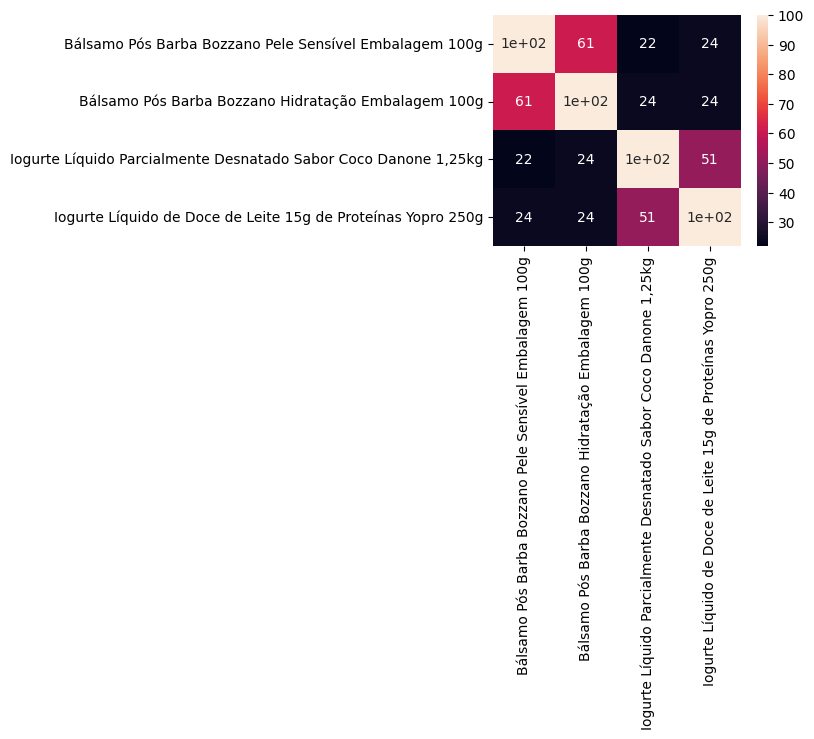

In [66]:
tags_set_morumbi = [ # coop---jd-morumbi-jd-morumbi.json
    # "Bálsamo Pós Barba Bozzano Pele Sensível Embalagem 100g"
    {"PRO": ["Bálsamo"], "MAR": ["Pós Barba"], "ESP": ["Bozzano", "Pele", "Sensível"], "TAM": ["100g"]},
    # "Bálsamo Pós Barba Bozzano Hidratação Embalagem 100g"
    {"PRO": ["Bálsamo"], "MAR": ["Pós Barba", "Bozzano"], "ESP": ["Hidratação"], "TAM": ["100g"]},
    # "Iogurte Líquido Parcialmente Desnatado Sabor Coco Danone 1,25kg"
    {"PRO": ["Iogurte"], "ESP": ["Líquido", "Parcialmente", "Desnatado", "Coco"], "MAR": ["Danone"], "TAM": ["1,25kg"]},
    # "Iogurte Líquido de Doce de Leite 15g de Proteínas Yopro 250g"
    {"PRO": ["Iogurte"], "ESP": ["Líquido", "Doce de Leite", "Proteínas"], "TAM": ["15g", "250g"], "MAR": ["Yopro"]}
]

labels = [
    "Bálsamo Pós Barba Bozzano Pele Sensível Embalagem 100g",
    "Bálsamo Pós Barba Bozzano Hidratação Embalagem 100g",
    "Iogurte Líquido Parcialmente Desnatado Sabor Coco Danone 1,25kg",
    "Iogurte Líquido de Doce de Leite 15g de Proteínas Yopro 250g"
]

similarity_matrix_example = np.array(
    [
        [similarity(tags1, tags2) for tags2 in tags_set_morumbi]
        for tags1 in tags_set_morumbi
    ]
)

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(similarity_matrix_example, annot=True, xticklabels = labels, yticklabels=labels, ax=ax)

If we had used a basic similarity from thefuzz, would it be different?

<Axes: >

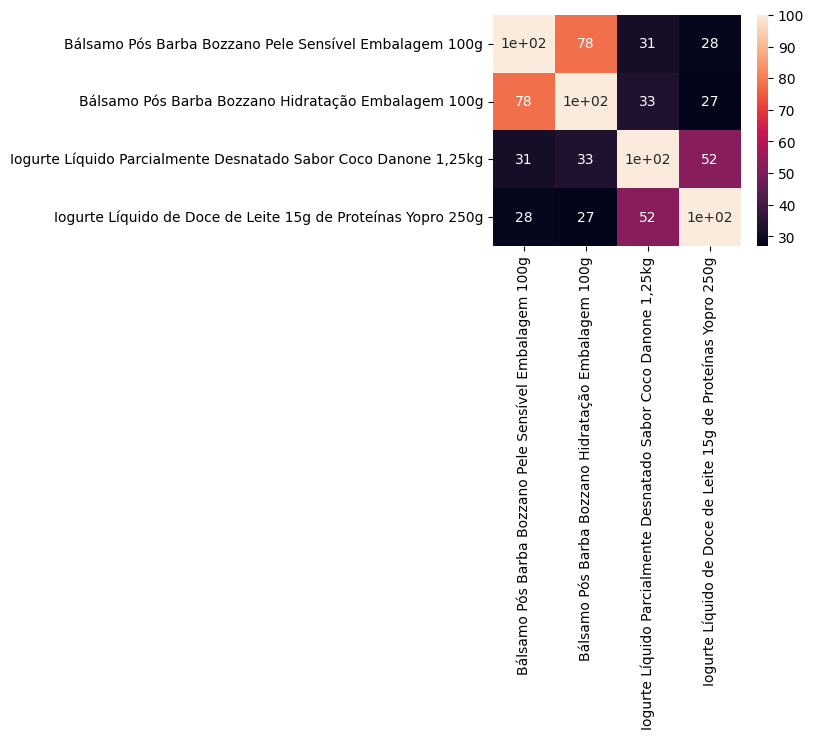

In [67]:
another_similarity_matrix_example = np.array(
    [
        [tfuzz.ratio(tags1, tags2) for tags2 in labels]
        for tags1 in labels
    ]
)

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(another_similarity_matrix_example, annot=True, xticklabels = labels, yticklabels=labels, ax=ax)

We see scores would get higher for distinct elements, so maybe it is worth using our own metrics, but only later. Next section uses rapidfuzz to build the similarity matrix fast.

## Build similarity matrix with rapidfuzz

In [68]:
from rapidfuzz import process, fuzz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
%%time
sim_matrix = process.cdist(texts, texts, dtype=np.int8, workers=8)

CPU times: total: 2min 29s
Wall time: 25.6 s


<span style="color:red">ATTENTION: similarities are in the range 0-100</span> (forgetting it prooved to be a common source of bugs for me...)

😀😀😀😀😀😀😀😀😀😀😀😀

In [70]:
sim_matrix.shape

(42581, 42581)

## Visualize similarity matrix

In [71]:
random_ids = np.random.choice(len(data), 3)
# we got 3 random elements, now we got 1 element similar to each of those so 
# we can check if the similarity is meaningful in both cases
to_add = []
for id1 in random_ids:
    close_elem = np.argsort(sim_matrix[id1])[-5]
    to_add.append(close_elem)
random_ids = random_ids.tolist() + to_add
random_ids

[7358, 16640, 2346, 26890, 4994, 2347]

<Axes: ylabel='Count'>

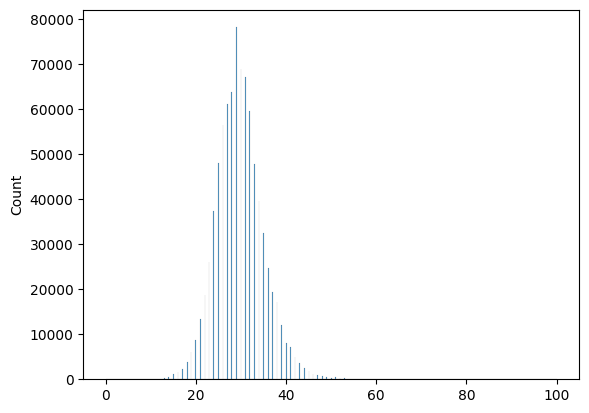

In [72]:
sns.histplot(x = sim_matrix[:20].flatten())

<Axes: >

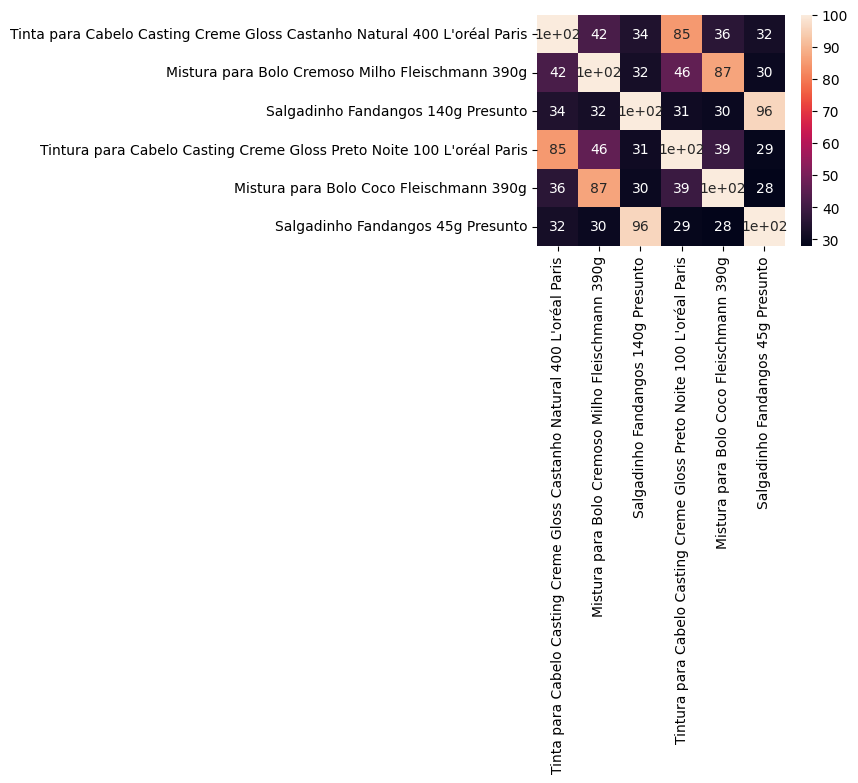

In [73]:
similarity_matrix_example = np.array(
    [
        [sim_matrix[id1][id2] for id1 in random_ids]
        for id2 in random_ids
    ]
)
labels = [texts[id] for id in random_ids]

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(similarity_matrix_example, annot=True, xticklabels = labels, yticklabels=labels, ax=ax)

In [74]:
# # RESCALE SIMILARITY MATRIX TO [0,1]
# sim_matrix = sim_matrix / 100

## Try simple clustering

### Idea 1 (Greedy)

**Input**: 
- similarity matrix NxN (ideally with similarity zero for products of same market)
- similarity threshold (> 0)
- dictionary id2market linking products IDs to their market id.

**Output**: 
- list or dict associating each product/node to a cluster number

**Algorithm**:

Start with greatest similarities and do the following:
- if the edge weight (i.e., the similarity) is smaller than threshold, stop loop \
  Alternatively, do this filter before sorting list of edges to visit in decreasing order of similairty (we must do a sort anyway...)
- if both nodes already belong to some cluster, skip
- if u is in cluster k and v has no cluster, add v to cluster k but only if v's market is not represented in that lister
- if none have a cluster, build a new cluster and add both

In the end, add all orphan products to their own cluster.

Needless to say that all edges must connect product from different markets...


First, force similarity to be zero for products in same market

In [75]:
from tqdm import tqdm

for id_list in market2id.values():
    for id1 in tqdm(id_list):
        for id2 in id_list:
            sim_matrix[id1][id2] = 0

  0%|          | 29/9443 [00:00<00:32, 288.51it/s]

100%|██████████| 10356/10356 [00:30<00:00, 342.12it/s]


Do clustering

In [76]:
from numba import njit

In [77]:
@njit(parallel=True)
def build_edge_list(matrix, thres):
    fair_sz = max(1, len(matrix) ** 2 // 1000)  # assume each product has similarity > threshold for less then 0.1% of all products
    leftnodes = np.ones(fair_sz)
    rightnodes = np.ones(fair_sz)
    similarities = np.ones(fair_sz)
    k = 0
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if j <= i:
                continue
            val = matrix[i][j]
            if val >= thres:
                leftnodes[k] = i
                rightnodes[k] = j
                similarities[k] = val
                k += 1
                # if k > fair_sz:
                #     print(f"\033[91mk = {k}, increase fair-sz in build_edge_list(..)\033[0m")
                #     return
    return k, leftnodes, rightnodes, similarities

In [78]:
# call njit-annotated function with small example so numba compiles tha function
build_edge_list(np.array([[1]]), 70)

(array([1.]), array([1.]), array([1.]))

In [79]:
build_edge_list(sim_matrix, 70)

(array([0., 0., 0., ..., 1., 1., 1.]),
 array([9.732e+03, 9.736e+03, 9.745e+03, ..., 1.000e+00, 1.000e+00,
        1.000e+00]),
 array([100.,  85.,  79., ...,   1.,   1.,   1.]))

In [80]:
# %%time

thres = 70  # similarity threshold (only similarities greater than that are considered)
N = len(data)
assert sim_matrix.shape == (N, N)
n_clusters = 0
print("array of products' clusters")
clusters = - np.ones(N, dtype=int) # clusters[prod of id N] is the cluster number
                               #! CONVENTION: VALID CLUSTER NUMBERS STARTING AT 0
cluster2markets = {}  # cluster number: list of markets present in cluster

print("building list to sort")
n_edges, leftnodes, rightnodes, similarities = build_edge_list(sim_matrix, thres)
edges = [(int(t[0]),int(t[1]),t[2]) for i, t in enumerate(zip(leftnodes, rightnodes, similarities)) if i < n_edges]

print(f"sorting valid edges (total of edges: {len(edges)})")
edges = sorted(edges, key=lambda t: t[2], reverse=True)

print("building clusters")
for e in tqdm(edges):
    # if both nodes already have a cluster, skip edge
    if clusters[e[0]] != -1 and clusters[e[1]] != -1:
        continue
    # if only one of the nodes has a cluster and the market of the other node is not yet 
    # represented in the cluster, add that unclustered node to the node
    if clusters[e[1]] != -1 and id2market[e[0]] not in cluster2markets[clusters[e[1]]]:
        clusters[e[0]] = clusters[e[1]]
        cluster2markets[clusters[e[1]]].append(id2market[e[0]])
        continue
    if clusters[e[0]] != -1 and id2market[e[1]] not in cluster2markets[clusters[e[0]]]:
        clusters[e[1]] = clusters[e[0]]
        cluster2markets[clusters[e[0]]].append(id2market[e[1]])
        continue
    # if both don't have a cluster, create new cluster and add both
    # NOTE: since entries for same market have been zeroed-out before starting the algorithm
    # and threshold > 0, then we know e[0] and e[1] are from different markets
    cluster = n_clusters
    n_clusters += 1
    clusters[e[0]] = cluster
    clusters[e[1]] = cluster
    cluster2markets[cluster] = [id2market[e[0]], id2market[e[1]]]

# do cluster for remaining products
for i, val in enumerate(clusters):
    if val == -1:
        clusters[i] = n_clusters
        n_clusters += 1

array of products' clusters
building list to sort
sorting valid edges (total of edges: 1813141)
building clusters


100%|██████████| 1813141/1813141 [00:01<00:00, 1328720.59it/s]


### Explore generated clusters

number of clusters

In [81]:
max(clusters) + 1 # nb clusters

25113

distribution of cluster sizes

<Axes: ylabel='Count'>

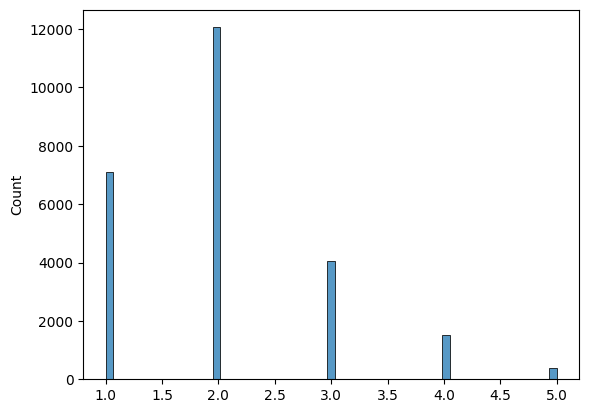

In [82]:
cluster_sizes = [len(val) for val in cluster2markets.values()] + \
                [1 for _ in range(max(clusters) - len(cluster2markets))]
                # this 2nd term is because singletons (clusters of 1 elem) are not in clisters2markets
sns.histplot(cluster_sizes)

sample some clusters

In [83]:
for cluster in np.random.choice(max(clusters), 10):
    products_ids = [i for i, c in enumerate(clusters) if c == cluster]
    print(f"Cluster #{cluster}:")
    for pid in products_ids:
        print("\t" + texts[pid])

Cluster #1220:
	Cerveja Zero Álcool Budweiser 350ml
Cluster #6864:
	Mortadela Perdigão 400g
	Mortadela Perdigão 400g
Cluster #7947:
	Protex Baby Sabonete Liquido Shower Gel Delicate Protec Refill 180ml
	Protex Baby Sabonete Liquido Shower Gel Delicate Protec Refill 180ml
	Protex Baby Sabonete Liquido Shower Gel Delicate Protec Refill 180ml
Cluster #6803:
	Margarina Qualy com Sal Light Zero Lactose 500g
	Margarina Qualy com Sal Light Zero Lactose 500g
Cluster #6840:
	Margarina Claybom Cremosa sem Sal Perdigão 500g
	Margarina Claybom Cremosa sem Sal Perdigão 500g
	Margarina Claybom Cremosa sem Sal Perdigão 500g
	Margarina Claybom Cremosa sem Sal Perdigão 500g
Cluster #19917:
	Grill Sanduicheira Preta Pratic Mondial Sn-01 220v
Cluster #20726:
	Tilápia Inteira Fresca
Cluster #13728:
	Pão de Queijo Recheado com Goiabada Confiare 300g
	Pao de Queijo com Goiabada Dia 300g
Cluster #12442:
	Frigideira em Alumínio Turim Preta 24cm Tramontina
Cluster #12437:
	Sabão em Barra Razzo Neutro Embalagem

Minimum similarity within clusters

In particular for greedy approaches, we may have elements that are not so similar within same cluster.. (bad)

In [84]:
from itertools import combinations

In [85]:
min_sims_in_cl = []

for cluster in tqdm(np.random.choice(max(clusters), 10000)):
    products_ids = [i for i, c in enumerate(clusters) if c == cluster]
    min_sim = 999999
    for p1, p2 in combinations(products_ids, 2):
        if sim_matrix[min(p1, p2)][max(p1, p2)] < min_sim:
            min_sim = sim_matrix[min(p1, p2)][max(p1, p2)]
    if min_sim < 999999:  # can be == 999999 for clusters of 1 element (singletons)
        min_sims_in_cl.append(min_sim)

100%|██████████| 10000/10000 [00:54<00:00, 182.50it/s]


In [86]:
len(min_sims_in_cl)

5124

<Axes: ylabel='Count'>

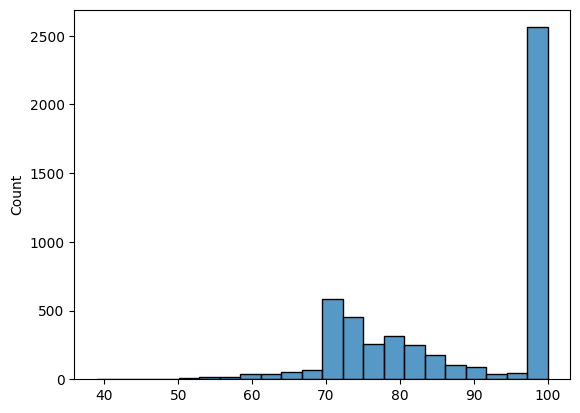

In [87]:
sns.histplot(min_sims_in_cl)

In [88]:
f"{100*sum([x < 70 for x in min_sims_in_cl])/len(min_sims_in_cl)}% clusters with a pair of elements with a similarity under 70%"

'4.8009367681498825% clusters with a pair of elements with a similarity under 70%'

Let us compare intra and intercluster similarities

In [97]:
clusters_subset = np.random.choice(max(clusters), 1000)
clusters_prods = [[i for i, c in enumerate(clusters) if c == cluster] for cluster in clusters_subset]

# inter-cluster
inter_sims = []
for i, prods in enumerate(clusters_prods):
    rows = prods
    columns = []
    for j, other_prods in enumerate(clusters_prods):
        if j == i:
            continue
        columns += other_prods
    intersim_matrix = sim_matrix[np.ix_(rows, columns)]
    inter_sims += intersim_matrix.flatten().tolist()

# intra-cluster
intra_sims = []
for prods in clusters_prods:
    intrasim_matrix = sim_matrix[np.ix_(prods, prods)]
    idxs = np.tril_indices(len(intrasim_matrix), -1) # only elements below diagonal (including diagonal, intracluster similarity distribution would be biased)
    intra_sims += intrasim_matrix[idxs].tolist()

<Axes: ylabel='Density'>

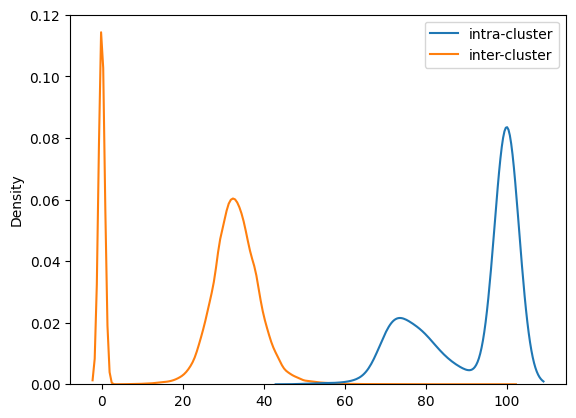

In [113]:
sns.kdeplot({"intra-cluster": intra_sims, "inter-cluster": inter_sims}, common_norm=False)

## Refine Similarity Matrix using NER model

In [114]:
from tqdm import tqdm
from numba import njit

In [115]:
@njit
def pairs2refine(m, thresh=70):
    l = []
    for i in range(len(m)):
        for j, val in enumerate(m[i][i+1:]):
            if thresh <= val < 100:
                l.append((i,j))
    return l

# compile with small example
pairs2refine(np.array([[20, 80], [100, 20]], dtype=np.int8))

[(0, 0)]

In [116]:
l = pairs2refine(sim_matrix)
print(len(l))

for i, j in tqdm(l):
    sim_matrix[i][j] = similarity(data[i]['tags'], data[j]['tags'])
    sim_matrix[j][i] = sim_matrix[i][j]

234307


100%|██████████| 234307/234307 [00:06<00:00, 37906.38it/s]


### Try new clustering and compare

In [117]:
# %%time

thres = 70  # similarity threshold (only similarities greater than that are considered)
N = len(data)
assert sim_matrix.shape == (N, N)
n_clusters = 0
print("array of products' clusters")
clusters = - np.ones(N, dtype=int) # clusters[prod of id N] is the cluster number
                               #! CONVENTION: VALID CLUSTER NUMBERS STARTING AT 0
cluster2markets = {}  # cluster number: list of markets present in cluster

print("building list to sort")
n_edges, leftnodes, rightnodes, similarities = build_edge_list(sim_matrix, thres)
edges = [(int(t[0]),int(t[1]),t[2]) for i, t in enumerate(zip(leftnodes, rightnodes, similarities)) if i < n_edges]

print(f"sorting valid edges (total of edges: {len(edges)})")
edges = sorted(edges, key=lambda t: t[2], reverse=True)

print("building clusters")
for e in tqdm(edges):
    # if both nodes already have a cluster, skip edge
    if clusters[e[0]] != -1 and clusters[e[1]] != -1:
        continue
    # if only one of the nodes has a cluster and the market of the other node is not yet 
    # represented in the cluster, add that unclustered node to the node
    if clusters[e[1]] != -1 and id2market[e[0]] not in cluster2markets[clusters[e[1]]]:
        clusters[e[0]] = clusters[e[1]]
        cluster2markets[clusters[e[1]]].append(id2market[e[0]])
        continue
    if clusters[e[0]] != -1 and id2market[e[1]] not in cluster2markets[clusters[e[0]]]:
        clusters[e[1]] = clusters[e[0]]
        cluster2markets[clusters[e[0]]].append(id2market[e[1]])
        continue
    # if both don't have a cluster, create new cluster and add both
    # NOTE: since entries for same market have been zeroed-out before starting the algorithm
    # and threshold > 0, then we know e[0] and e[1] are from different markets
    cluster = n_clusters
    n_clusters += 1
    clusters[e[0]] = cluster
    clusters[e[1]] = cluster
    cluster2markets[cluster] = [id2market[e[0]], id2market[e[1]]]

# do cluster for remaining products
for i, val in enumerate(clusters):
    if val == -1:
        clusters[i] = n_clusters
        n_clusters += 1

array of products' clusters
building list to sort
sorting valid edges (total of edges: 1813141)
building clusters


100%|██████████| 1813141/1813141 [00:01<00:00, 1598676.25it/s]


### Explore generated clusters

number of clusters

In [118]:
max(clusters) + 1 # nb clusters

25111

distribution of cluster sizes

<Axes: ylabel='Count'>

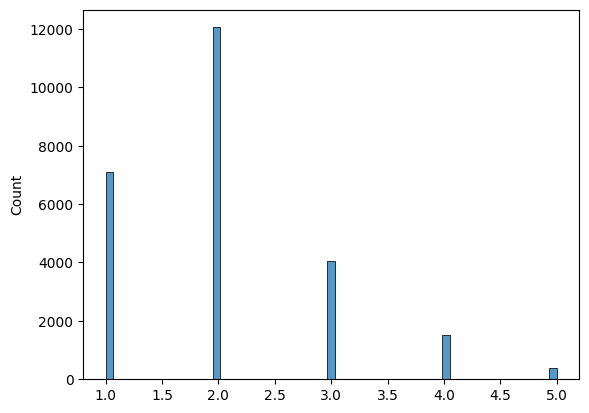

In [119]:
cluster_sizes = [len(val) for val in cluster2markets.values()] + \
                [1 for _ in range(max(clusters) - len(cluster2markets))]
                # this 2nd term is because singletons (clusters of 1 elem) are not in clisters2markets
sns.histplot(cluster_sizes)

sample some clusters

In [120]:
for cluster in np.random.choice(max(clusters), 10):
    products_ids = [i for i, c in enumerate(clusters) if c == cluster]
    print(f"Cluster #{cluster}:")
    for pid in products_ids:
        print("\t" + texts[pid])

Cluster #21542:
	Máscara Facial L'oréal Tecido Revitalift Hialurônico
Cluster #17103:
	Macarrão de Sêmola com Ovos Parafuso Speciale Pacote Vitarella 400g
	Macarrão de Sêmola com Ovos Espaguetinho 9 Adria Pacote 500g
Cluster #131:
	Combo L6p5 em suas barras preferidas
Cluster #22892:
	Esmalte Colorama Cremoso Mauve Urban Embalagem 8ml
Cluster #1230:
	Domecq Coquetel Composto Nacional 1l
	Domecq Coquetel Composto Nacional 1l
Cluster #11035:
	Folha de Louro Kodilar Pacote 7g
	Folha de Louro Qualitá Pacote 4g
Cluster #8486:
Cluster #695:
	Chá Verde Limão Antioxidante Leão 1,5l
	Chá Verde Limão Antioxidante Leão 1,5l
	Chá Verde Limão Antioxidante Leão 1,5l
Cluster #16809:
	Goma de Mascar Cliss Tutti-Frutti 12 Unidades
	Goma de Mascar Tutti Frutti Trident 8g
Cluster #5063:
	Limpador Perfumado Veja Jasmin do Caribe - 1l
	Limpador Perfumado Veja Jasmin do Caribe - 1l
	Limpador Perfumado Veja Jasmin do Caribe - 1l


Minimum similarity within clusters

In particular for greedy approaches, we may have elements that are not so similar within same cluster.. (bad)

In [121]:
from itertools import combinations

In [122]:
min_sims_in_cl = []

for cluster in tqdm(np.random.choice(max(clusters), 10000)):
    products_ids = [i for i, c in enumerate(clusters) if c == cluster]
    min_sim = 999999
    for p1, p2 in combinations(products_ids, 2):
        if sim_matrix[min(p1, p2)][max(p1, p2)] < min_sim:
            min_sim = sim_matrix[min(p1, p2)][max(p1, p2)]
    if min_sim < 999999:  # can be == 999999 for clusters of 1 element (singletons)
        min_sims_in_cl.append(min_sim)

100%|██████████| 10000/10000 [00:55<00:00, 179.54it/s]


In [123]:
len(min_sims_in_cl)

5092

<Axes: ylabel='Count'>

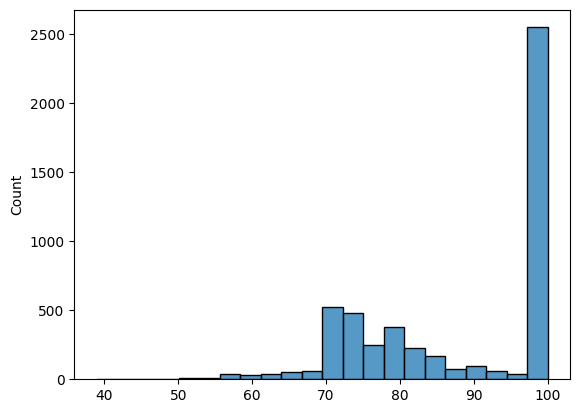

In [124]:
sns.histplot(min_sims_in_cl)

In [125]:
f"{100*sum([x < 70 for x in min_sims_in_cl])/len(min_sims_in_cl)}% clusters with a pair of elements with a similarity under 70%"

'4.791830322073841% clusters with a pair of elements with a similarity under 70%'

Let us compare intra and intercluster similarities

In [126]:
clusters_subset = np.random.choice(max(clusters), 1000)
clusters_prods = [[i for i, c in enumerate(clusters) if c == cluster] for cluster in clusters_subset]

# inter-cluster
inter_sims = []
for i, prods in enumerate(clusters_prods):
    rows = prods
    columns = []
    for j, other_prods in enumerate(clusters_prods):
        if j == i:
            continue
        columns += other_prods
    intersim_matrix = sim_matrix[np.ix_(rows, columns)]
    inter_sims += intersim_matrix.flatten().tolist()

# intra-cluster
intra_sims = []
for prods in clusters_prods:
    intrasim_matrix = sim_matrix[np.ix_(prods, prods)]
    idxs = np.tril_indices(len(intrasim_matrix), -1) # only elements below diagonal (including diagonal, intracluster similarity distribution would be biased)
    intra_sims += intrasim_matrix[idxs].tolist()

<Axes: ylabel='Density'>

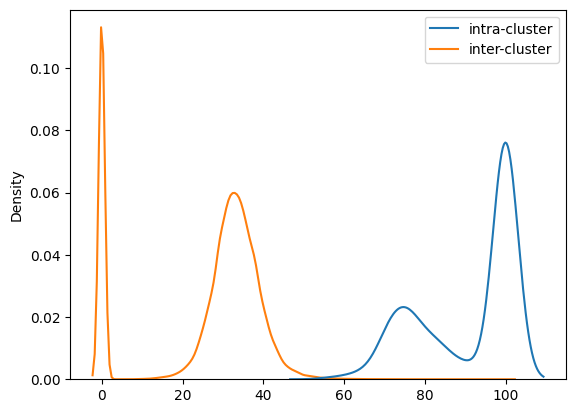

In [127]:
sns.kdeplot({"intra-cluster": intra_sims, "inter-cluster": inter_sims}, common_norm=False)

**Using our own metric didn't change much** (and it is slower...)

### Try another metric as well?

IDEA: weight of 0.5 for TAM and QUA